In [1]:
import skimage.io
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from skimage.transform import iradon

import seaborn as sns

%matplotlib inline

# Drae a set of emitters and detectors

# Get a point as a pixel location
def point_to_pixel(x, y, w, h):
    xp = int(min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds
    yp = int(min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

# Floating point version (for interpolation methods later)
def point_to_pixelf(x, y, w, h):
    xp = (min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds - a little less accurate but hey
    yp = (min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

def draw_des(ds, es, width, height):

    ## Cairo STUFF

    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, width, height)
    ctx = cairo.Context (surface)

    ctx.set_source_rgb(1,1,1)
    ctx.rectangle(0,0,width,height)
    ctx.fill()

    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)

    ## Back to the good stuff

    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()

    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)

    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)
        
    return surface

def draw_des_surf(surface, ds, es, width, height):
    ctx = cairo.Context (surface)
    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)
    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()
    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
        
    return surface

def get_paths(img, ds, es, width, height):
    # Does interpolation along all paths from emitters to detectors, given an image, detectors and emitters
    lines = []
    for e in es:
        for d in ds:
            y0, x0 = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height) # E loc
            y1, x1 = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height) # d loc

            # Make samplng points
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

            # Extract the values along the line
            zi = img[x.astype(np.int), y.astype(np.int)]
            lines.append(sum(zi))
    return lines

def test_image(w, h, r, x, y):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    xp, yp = point_to_pixel(x, y, w, h)
#     xp -= r
#     yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.arc(xp, yp, r, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def p1(w, h):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    x, y = 0, 0
    xp, yp = point_to_pixel(x, y, w, h)
#     xp -= r
#     yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.rectangle(xp, yp, w/4, h/4)
    ctx.rectangle(xp-w/4, yp-h/4, w/4, h/4)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def rotate_des(ds, es, angle):
    for d in ds:
        d['a'] += angle
    for e in es:
        e['a'] += angle
    return ds, es

48


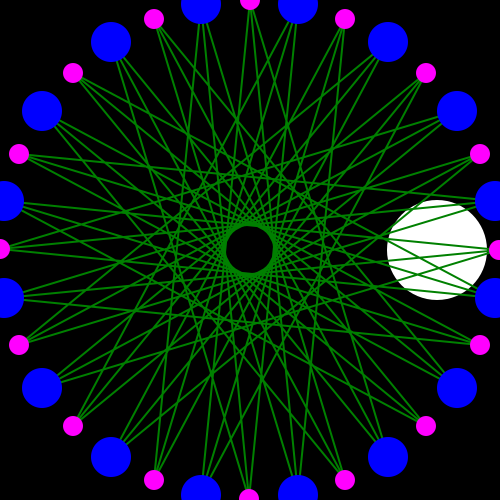

In [2]:
def draw_des_surf_sparse(surface, ds, es, width, height, n):
    ctx = cairo.Context (surface)
    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)
    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        low = (es.index(e)-int(n/2))
        high = (es.index(e)+int(n/2))
        if n%2 == 1:
            high += 1
        for dp in range(low, high):
            if dp>=len(ds):
                dp -= len(ds)
            d = ds[dp]
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()
    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
        
    return surface

def get_sparse_paths(img, ds, es, width, height, n):
    # Does interpolation along all paths from emitters to detectors, given an image, detectors and emitters
    lines = []
    for e in es:
        low = (es.index(e)-int(n/2))
        high = (es.index(e)+int(n/2))
        if n%2 == 1:
            high += 1
        for dp in range(low, high):
            if dp>=len(ds):
                dp -= len(ds)
            d = ds[dp]
            y0, x0 = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height) # E loc
            y1, x1 = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height) # d loc

            # Make samplng points
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

            # Extract the values along the line
            zi = img[x.astype(np.int), y.astype(np.int)]
            lines.append(sum(zi))
    return lines

es = []
ds = []

for i in range(16):
    d = {
        'r':1, # Distance from center relative to furthest object
        'a':math.pi*(i/2+0.25)/4, #2*math.pi*i/8,
    }
    e = {
        'r':1, # Distance from center relative to furthest object
        'a':math.pi + math.pi*(i/2)/4, #2*math.pi*i/8,
    }
    ds.append(d)
    es.append(e)
# pd.DataFrame(ds)

tis, tii, x, y = test_image(500, 500, 50, 0.75, 0)
tis.write_to_png('ti.png')
Image('ti.png')

print(len(get_sparse_paths(tii, ds, es, 500, 500, 3)))

s = draw_des_surf_sparse(tis, ds, es, 500, 500, 3)
fn = 'ring_of_16_circle_sparse_5.png'
s.write_to_png(fn)
Image(fn)

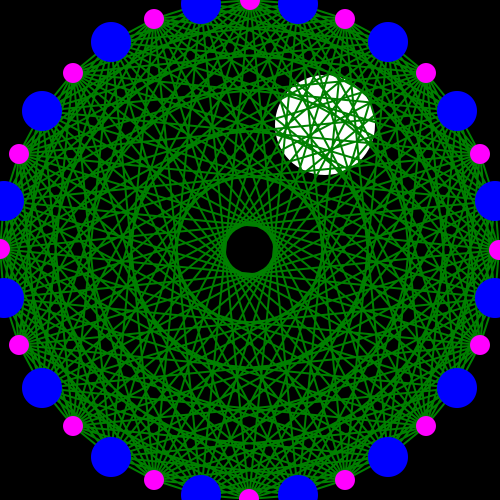

In [3]:
fn = 'ring_of_16_circle.png'
Image(fn)

In [4]:
X16 = []
X5 = []
Y = []

for i in range(1500):
    r = random.random()*0.75 # Get whole shape within circle
    rand = random.choice([0, 1, 2, 3])
#     a = rand*math.pi/2 + (random.random()*math.pi/2 - math.pi/4)
    a = random.random()*math.pi*2
    x, y = r*math.cos(a), r*math.sin(a)
    tis, tii, x, y = test_image(500, 500, 50, r*math.cos(a), r*math.sin(a))
    path16 = get_paths(tii, ds, es, 500, 500)
    path5 = get_sparse_paths(tii, ds, es, 500, 500, 5)
#     for p in range(len(path)):
#         path[p] += random.random()*100
    X16.append(path16)
    X5.append(path5)
    Y.append([x, y])

KeyboardInterrupt: 

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X5, Y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
mlpc.fit(X_train, y_train)

pred = mlpc.predict(X_test)

xe = []
ye = []
for i in range(len(pred)):
    p = pred[i]
    a = y_test[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))


mean of errors: 0.05188494437354174
Standard deviation of errors: 0.04811635046333815


/home/jonathan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 0.4)

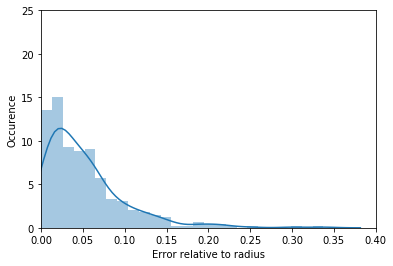

In [9]:
print("mean of errors:",np.asarray(ye).mean())
print("Standard deviation of errors:",np.asarray(ye).std())
# sns.set(color_codes=True)
ax = sns.distplot(ye);
ax.set_xlabel('Error relative to radius')
ax.set_ylabel('Occurence')
ax.set_ylim((0,25))
ax.set_xlim((0,0.4))
# plt.savefig('ring_of_16_error_distribution_16.png')

In [122]:
s = 0
for e in ye:
    if e < 0.05:
        s += 1

print(s/len(ye))



0.608


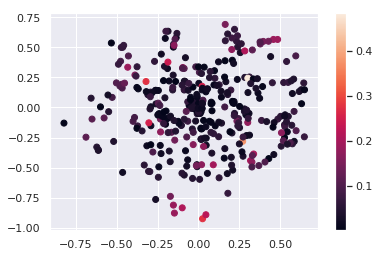

In [134]:



xe = []
ye = []
xp = []
yp = []
for i in range(len(pred)):
    p = pred[i]
    a = y_test[i]
    xe.append(abs(p[0]-a[0]))
    ye.append(abs(p[1]-a[1]))
    xp.append(p[0])
    yp.append(p[1])
plt.scatter(xp, yp, c=ye)
plt.colorbar()

In [ ]:

    
    
# ns = []
# scores16 = []
# for i in range(1,100):
#     mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
#     mlpc.fit(X_train[:i*10], y_train[:i*10])
#     scores16.append(mlpc.score(X_test, y_test))
#     ns.append(i*10)
    
    
# X_train, X_test, y_train, y_test = train_test_split(X5, Y)
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# scores5 = []
# for i in range(1,100):
#     mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
#     mlpc.fit(X_train[:i*10], y_train[:i*10])
#     scores5.append(mlpc.score(X_test, y_test))

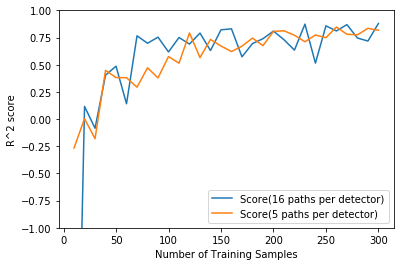

In [81]:
plt.ylim((-1, 1))
plt.plot(ns[:30], scores16[:30], label='Score(16 paths per detector)')
plt.plot(ns[:30], scores5[:30], label='Score(5 paths per detector)')
plt.legend()
plt.xlabel('Number of Training Samples')
plt.ylabel('R^2 score')
plt.savefig('ring_of_16_sparse_paths_performance.png')

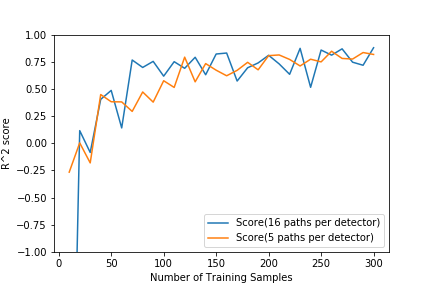

In [80]:
Image('ring_of_16_sparse_paths_performance.png')

In [8]:
paths = []
spaths = []
quads = []
objs = []
for i in range(1500):
    r = 0.2 + random.random()*0.55 # Get whole shape within circle
    rand = random.choice([0, 1, 2, 3])
    a = rand*math.pi/2 + (random.random()*math.pi/2 - math.pi/4)
    tis, tii, x, y = test_image(500, 500, 50, r*math.cos(a), r*math.sin(a))
    path = get_paths(tii, ds, es, 500, 500)
    for p in range(len(path)):
        path[p] += random.random()*100
    paths.append(path)
    path = get_sparse_paths(tii, ds, es, 500, 500, 5)
    for p in range(len(path)):
        path[p] += random.random()*100
    spaths.append(path)
    quads.append(rand)
    objs.append(0)

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scores = []
sscores = []

for i in range(10):

    X_train, X_test, y_train, y_test = train_test_split(paths, quads)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    mlpc = MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
    mlpc.fit(X_train, y_train)
    scores.append(mlpc.score(X_test, y_test))
    
    X_train, X_test, y_train, y_test = train_test_split(spaths, quads)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    mlpc = MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
    mlpc.fit(X_train, y_train)
    sscores.append(mlpc.score(X_test, y_test))

In [10]:
np.mean(scores)

0.9728

In [11]:
np.mean(sscores)

0.9906666666666668